# DeepSom: Simple Visualization using Word2Vec and t-SNE
### Notebook 2

#### By TJ Cycyota
##### Thanks to [Jeff Delaney](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne) for inspiration

### Hypothesis
We can visualize similarities between words used to describe wine using multiple dimensionality-reduction techniques, including Word2Vec and t-SNE.

### Steps:
1. Clean the data
2. Build a corpus
3. Train a Word2Vec Model
4. Visualize t-SNE representationso of the most common words


### Import packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
nltk.download('stopwords')

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomas.j.cycyota/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the Data
If you're just joining us and didn't read the first notebook, data was previously scraped using the file 'scrape-winemag.py'. The dataset can be found on [Kaggle](https://www.kaggle.com/zynicide/wine-reviews) or you can run Zack Thoutt's sraper on [Github](https://github.com/zackthoutt/wine-deep-learning). The line below loads the dataset included in this repo.

In [2]:
data = pd.read_json('winemag-data.json', dtype={
    'points': np.int32,
    'price': np.float32,
})

In [3]:
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.width', 1000)
data.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,France,"This Chardonnay-based wine, with 10% Chenin Blanc, opens with aromas of pressed yellow flowers, peach blossom and just-ripe tropical fruit. There's good zip to the bright fruit flavors, finishing fresh and clean. Drink now.",None,87,10.0,Languedoc-Roussillon,Pays d'Oc,None,Lauren Buzzeo,@laurbuzz,Domaine Rives-Blanques 2016 White (Pays d'Oc),White Blend,Domaine Rives-Blanques


### NLTK Function Definition
We need to define a few functions to clean our wine reviews, before we visualize them. We'll also define our stop words, or list of words that in English add little value to an overall natural-language analysis of text. Some eaamples might be: it, so, the, is. 

To see the full list of stopwords for all languages (e.g. not just English words), type:
>print(STOP_WORDS)

In [4]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    #Remove chars that are not letters or numbers; downcase; remove stop words
    regex = re.compile('([^\s\w\-\%]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)
            
    sentence = " ".join(sentence)
    return sentence
    
def clean_dataframe(frame, columns):
    "frame is a pandas dataframe; column is an array of column names"
    #Drop NaNs (not needed); apply 'clean_sentence' function to Description
    #frame = frame.dropna(how="any")
    
    for col in columns:
        frame[col] = frame[col].apply(clean_sentence)
    return frame

Now we can apply these functions to the 'description' column in our wine reviews dataset. You see that we make this edit 'in-place', meaning the existing column is edited instead of making a new column for the cleaned data.

In [5]:
data_cleaned = data.copy()
data_cleaned = clean_dataframe(data_cleaned, ["description", "title"])
data_cleaned.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,France,chardonnay-based wine 10% chenin blanc opens aromas pressed yellow flowers peach blossom just-ripe tropical fruit theres good zip bright fruit flavors finishing fresh clean drink,None,87,10.0,Languedoc-Roussillon,Pays d'Oc,None,Lauren Buzzeo,@laurbuzz,domaine rives-blanques 2016 white pays doc,White Blend,Domaine Rives-Blanques


Now we can write a short function 'build_corpus' to split our sentences into word tokens. We will preserve the sentence structure in list of list form. 

In [6]:
def build_corpus(data, columns):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in columns:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

In [7]:
corpus = build_corpus(data_cleaned, ["description"])
corpus[0:2]

[['chardonnay-based',
  'wine',
  '10%',
  'chenin',
  'blanc',
  'opens',
  'aromas',
  'pressed',
  'yellow',
  'flowers',
  'peach',
  'blossom',
  'just-ripe',
  'tropical',
  'fruit',
  'theres',
  'good',
  'zip',
  'bright',
  'fruit',
  'flavors',
  'finishing',
  'fresh',
  'clean',
  'drink'],
 ['wood',
  'aromas',
  'spice',
  'show',
  'strongly',
  'wine',
  'palate',
  'toasty',
  'character',
  'gives',
  'bitter',
  'edge',
  'ripe',
  'red',
  'fruits',
  'needs',
  'go',
  'wait',
  'drink',
  'wine',
  '2019']]

## Word2Vec Implementation

We'll use Word2Vec to prepare the data for visualization. For more details on the implementation of Word2Vec, check out the earlier notebook in this series titled "01_DeepSom_XplrtryDataAnalysis". Prepares data for visualization by converting each text word into a numeric vector of size="size".

In [8]:
w2v = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
w2v.wv["wine"]

array([ 1.40872570e-02, -2.26285249e-01,  5.88200092e-01, -1.43053010e-01,
       -4.25160348e-01, -1.83288619e-01, -2.68338621e-01, -6.93744496e-02,
        3.50509763e-01,  3.16005826e-01, -5.75806439e-01, -1.63815826e-01,
       -2.36196965e-01,  1.11996740e-01, -2.13355273e-01,  4.09689367e-01,
       -3.81281555e-01,  4.31281030e-01, -5.00185266e-02, -1.22120649e-01,
        7.85995275e-02,  1.23959437e-01,  8.31478417e-01,  2.09149808e-01,
        1.04672536e-01,  3.94986302e-01, -3.89846891e-01,  5.04551589e-01,
       -1.00775369e-01, -8.58130038e-01,  4.88869458e-01,  2.29552358e-01,
        1.55006364e-01,  2.51132876e-01, -1.94471970e-01,  1.82856005e-02,
        6.20877594e-02, -5.44790864e-01, -3.28004599e-01, -1.56669378e-01,
       -9.96741951e-01, -8.11299235e-02, -6.01012609e-04,  3.17692682e-02,
        1.82229683e-01,  8.42636302e-02, -3.31073105e-01,  5.78830421e-01,
        1.37738466e-01,  9.51087475e-02,  1.50009975e-01, -6.32358575e-03,
        4.88920473e-02,  

## t-SNE Implementation

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically the 2D plane. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data. But since t-SNE complexity is significantly high, usually we'd use other high-dimension reduction techniques before applying t-SNE (hence why we've used Word2Vec prior to here). 

The great news about TSNE is that it allows us to visualize our data on a 2D plane!


In [9]:
def tsne_plot(model):
    "Creates a t-SNE model; plots it"
    labels = []
    tokens = []
    
    #Get the entire vocab from the Word2Vec model
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
    #Configure and fit sklearn's t-SNE model
    tsne_model = TSNE(init='pca', random_state=1)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext = (5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    plt.show()
        

/Users/thomas.j.cycyota/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


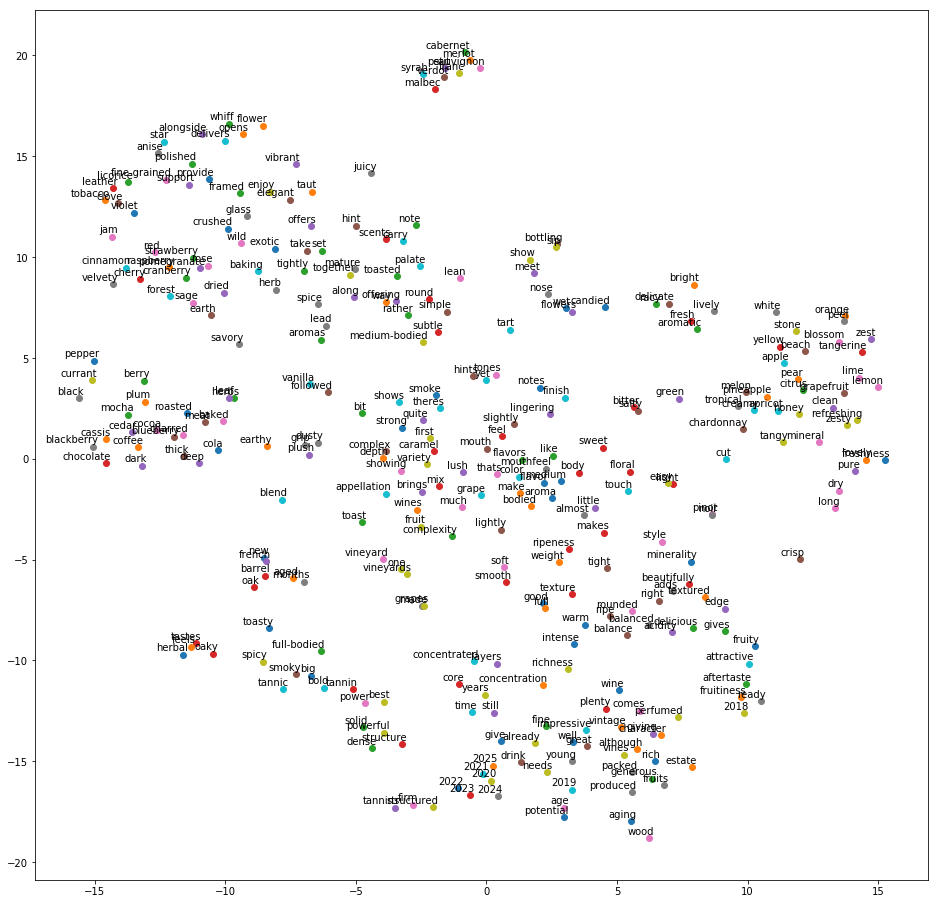

In [10]:
tsne_plot(w2v)

It's quite interesting to look at this plot! We can start to see groupings of adjectives and nouns that could be commonly associated with similar types of wines, which makes sense considering that similar wines exhibit similar tasting properties. You may see different results if you re-run the notebook. 

For example, we can see a grouping of varietals at 'top-center': malbec, merlot, cabernet, etc. Also, roughly along 0 on the y-axis, we see much darker wines at left (blackberry, chocolate, black, pepper) and lighter wines at right (pear, lemon, clean, refreshing, dry). 